# Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates


In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

_________
### upsampler func def

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [6]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="score="+str(score))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")



In [7]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        model_final = copy.deepcopy(pipe)
        model_final.set_params(**best_params)
        model_final.fit(X_train, y_train.values.ravel())
    else:
        model_final = None

    return score, best_params, model_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [9]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [10]:
# get table from database
# database = "data.sqlite"
# con = sqlite3.connect(database)

# X_train = pd.read_sql_query("SELECT * from X_train", con)
# y_train = pd.read_sql_query("SELECT * from y_train", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_train = X_train.set_index(index_c)
# y_train = y_train.set_index(index_c)

# X_train1 = X_train[~X_train.scr_umol_l.isna()]
# y_train1 = y_train[~X_train.scr_umol_l.isna()]

# X_test = pd.read_sql_query("SELECT * from X_test", con)
# y_test = pd.read_sql_query("SELECT * from y_test", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_test = X_test.set_index(index_c)
# y_test = y_test.set_index(index_c)

# y_test = y_test[~X_test.scr_umol_l.isna()]
# X_test = X_test[~X_test.scr_umol_l.isna()]


# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)





In [11]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [12]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [13]:
query = "select * from AKI_ICU_JOIN_day1plus_SD"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])

In [14]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [15]:
data.columns

Index(['aki_kdigo_grade_1', 'aki_kdigo_grade_2', 'aki_kdigo_grade_3',
       'day_detection_kdigo_grade_1', 'day_detection_kdigo_grade_2',
       'day_detection_kdigo_grade_3', 'aki_mkdigo_grade_1',
       'aki_mkdigo_grade_2', 'aki_mkdigo_grade_3',
       'day_detection_mkdigo_grade_1',
       ...
       'supplemental_oxygen', 'invasive_vent', 'hfnc', 'non_invasive_vent',
       'tracheostomy', 'min_day_rrt_present', 'min_day_rrt_active',
       'weight_admit', 'weight_min', 'weight_max'],
      dtype='object', length=105)

In [16]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

# outcome_var.append('min_day_rrt_present')


# first_24h = 1
# data= data[data[outcome_var].min(axis=1)>first_24h]

In [17]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [18]:
data = data[data['ckd']==0]

In [19]:
data = data[data['kidney_transplant']==0]

In [20]:
data.head(5)

,,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,ckd,kidney_transplant,congestive_heart_failure,diabetes_type2,chronic_kidney_disease,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial_infarct,chronic_pulmonary_disease,aschronic_heart_failure,sepsis,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,wbc_bd_min,wbc_bd_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,pt_min,pt_max,thrombin_min,thrombin_max,ptt_min,ptt_max,inr_min,inr_max,bilirubin_total_min,bilirubin_total_max,egfr_epi_scr_max,egfr_mdrd_scr_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,bmi,urineoutput_24hr,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_admit,weight_min,weight_max
stay_id,subject_id,hadm_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30003125,16165135,24791729,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,60.0,0,WHITE,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,38.0,38.0,13.0,13.0,150.0,150.0,9.9,9.9,9.9,9.9,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,26.0,26.0,14.0,14.0,8.4,8.4,103.0,103.0,0.7,0.7,141.0,141.0,139.0,139.0,3.6,3.6,13.2,13.2,NaN,NaN,28.4,28.4,1.2,1.2,NaN,NaN,103.0,115.0,59.0,95.0,73.230769,104.0,153.0,128.500000,47.0,73.0,60.433333,11.0,26.0,19.653846,36.89,37.39,37.127143,94.0,100.0,NaN,150.0,1,0,0,0,0,99999999.0,99999999.0,73.2,73.2,73.2
30004242,17220323,25700666,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,75.0,1,BLACK/AFRICAN AMERICAN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,31.5,32.6,10.5,11.0,280.0,289.0,7.9,9.4,7.9,9.4,NaN,NaN,NaN,NaN,NaN,NaN,15.0,16.0,24.0,24.0,8.0,10.0,8.6,9.1,100.0,105.0,0.5,0.6,123.0,135.0,136.0,141.0,3.3,3.9,11.3,11.3,NaN,NaN,24.9,24.9,1.0,1.0,NaN,NaN,89.0,97.0,41.0,78.0,59.206897,92.0,159.0,130.225806,34.0,90.0,51.354839,10.0,21.0,15.793103,36.61,37.11,36.806667,94.0,100.0,NaN,400.0,1,0,0,0,0,99999999.0,99999999.0,76.2,76.2,79.0
30004627,12844527,27959182,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,63.0,0,BLACK/AFRICAN AMERICAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.2,33.5,10.2,11.3,171.0,205.0,7.8,10.7,7.8,10.7,NaN,NaN,NaN,NaN,NaN,NaN,12.0,13.0,23.0,24.0,29.0,29.0,8.2,8.8,106.0,107.0,1.0,1.2,135.0,148.0,138.0,139.0,4.1,4.1,13.0,13.0,NaN,NaN,28.1,28.1,1.2,1.2,NaN,NaN,64.0,61.0,55.0,81.0,71.000000,109.0,156.0,132.766667,43.0,83.0,66.900000,8.0,21.0,15.586207,36.28,36.94,36.665714,95.0,100.0,NaN,60.0,0,1,0,0,0,99999999.0,99999999.0,81.0,81.0,81.0
30006565,15524760,28718343,0,0,0,9999999.0,9999999.0,9999999.0,1,1,0,2.0,9999999.0,9999999.0,56.0,0,WHITE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.1,50.6,13.0,17.0,226.0,335.0,17.2,24.1,17.2,24.1,NaN,NaN,NaN,NaN,NaN,NaN,13.0,20.0,21.0,22.0,21.0,25.0,8.3,8.5,101.0,106.0,0.8,1.0,98.0,104.0,136.0,139.0,4.2,4.3,13.5,13.5,NaN,NaN,33.8,33.8,1.2,1.2,1.2,1.2,84.0,77.0,69.0,101.0,80.500000,92.0,137.0,109.285714,53.0,84.0,65.142857,10.0,39.0,19.413043,37.11,38.67,37.628889,89.0,100.0,41.17,75.0,0,1,0,0,0,99999999.0,99999999.0,74.1,74.1,80.9
30011241,14731650,28724382,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,82.0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,25.7,26.4,8.0,8.4,144.0,157.0,11

In [21]:
data[data.chronic_kidney_disease==1]

,,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,ckd,kidney_transplant,congestive_heart_failure,diabetes_type2,chronic_kidney_disease,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial_infarct,chronic_pulmonary_disease,aschronic_heart_failure,sepsis,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,wbc_bd_min,wbc_bd_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,pt_min,pt_max,thrombin_min,thrombin_max,ptt_min,ptt_max,inr_min,inr_max,bilirubin_total_min,bilirubin_total_max,egfr_epi_scr_max,egfr_mdrd_scr_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,bmi,urineoutput_24hr,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_admit,weight_min,weight_max
stay_id,subject_id,hadm_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [24]:
data.dropna(axis=1, thresh = int(0.8*data.shape[0]), inplace=True)

In [22]:
pd.set_option('display.max_rows', None)

In [25]:
data.isna().sum()/len(data)*100

aki_kdigo_grade_1                0.000000
aki_kdigo_grade_2                0.000000
aki_kdigo_grade_3                0.000000
day_detection_kdigo_grade_1      0.000000
day_detection_kdigo_grade_2      0.000000
day_detection_kdigo_grade_3      0.000000
aki_mkdigo_grade_1               0.000000
aki_mkdigo_grade_2               0.000000
aki_mkdigo_grade_3               0.000000
day_detection_mkdigo_grade_1     0.000000
day_detection_mkdigo_grade_2     0.000000
day_detection_mkdigo_grade_3     0.000000
age                              0.000000
female                           0.000000
ethnicity                       17.162277
ckd                              0.000000
kidney_transplant                0.000000
congestive_heart_failure         0.000000
diabetes_type2                   0.000000
chronic_kidney_disease           0.000000
hypertension                     0.000000
obesity_icd                      0.000000
peripheral_vascular_disease      0.000000
chronic_liver_disease            0

In [ ]:
# prediction_window = 3

# data.loc[(((data['aki_kdigo_grade_1']== 1)| (data['aki_kdigo_grade_2']== 1) | (data['aki_kdigo_grade_3']==1)) \
#     &( (data['day_detection_kdigo_grade_1']<=prediction_window)| (data['day_detection_kdigo_grade_2']<=prediction_window) | (data['day_detection_kdigo_grade_3']<=prediction_window)) \
#         |(data['min_day_rrt_present']<= prediction_window)), 'outcome'] = 1


# data.loc[data.outcome.isna(),'outcome']=0

In [26]:
prediction_window = 2

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [27]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

In [28]:
data.outcome.value_counts()

0.0    19960
1.0     2403
Name: outcome, dtype: int64

## Missingness percentage

In [ ]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [ ]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [29]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

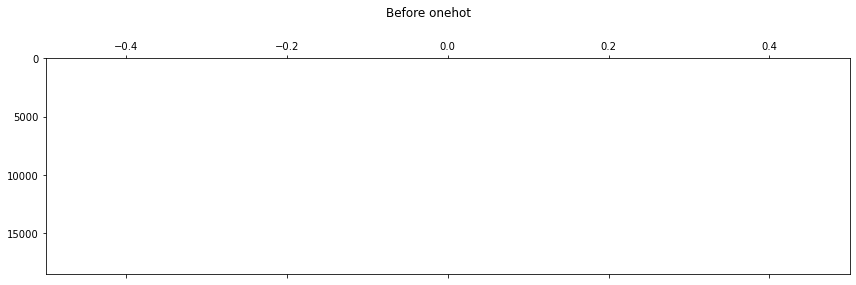

In [30]:
data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
                                            .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
                                            .fillna('other').pipe(onehot)

In [ ]:
data_cat.head(5)

In [31]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True)

In [32]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3'
]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y))
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [38]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split


X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y) # 

X_train, X_valid, y_train, y_valid = train_test_split(X_train_0, y_train_0, test_size=0.2, random_state=42, shuffle=True, stratify=y_train_0)

In [39]:
X_train, y_train = up_sample(X_train, y_train,'outcome')

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [35]:
df_y.value_counts()

outcome
0.0        16514
1.0         2011
dtype: int64

___________________
### Define pipeline

In [40]:
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(steps=[
# ('resample', upsampler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('scaler', MinMaxScaler()),
('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

___________________
### Cross validation search

In [ ]:
########### **************************************8
# Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


param_grid = {
    'model__n_estimators': [100, 500 ],
    'model__max_depth': [ 30 , 40, 50 , 60 , 80, 100],
    'model__min_samples_leaf': [100, 70, 50,20, 10,5],
    'model__min_samples_split' : [100, 70, 50,20, 10,5]
}

# param_grid ={'model__max_depth': [6, 10], 
#    }




score, best_params, model_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# dump(model_final , open('model_final_LGBM.pkl', 'wb'))

__________
### Fitting Pipeline one time



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



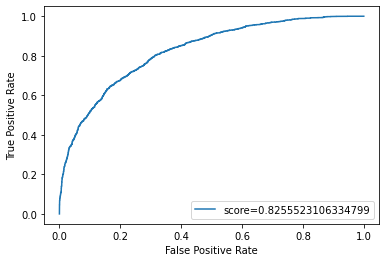

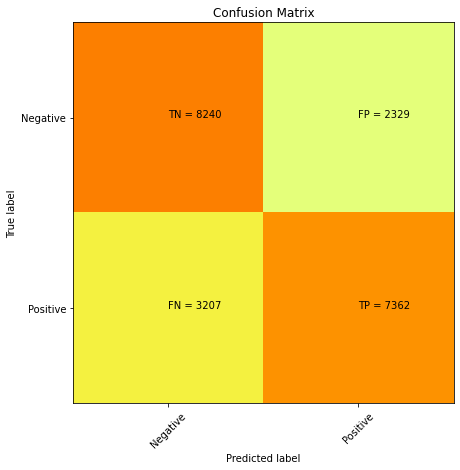


Classification report

              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75     10569
         1.0       0.76      0.70      0.73     10569

    accuracy                           0.74     21138
   macro avg       0.74      0.74      0.74     21138
weighted avg       0.74      0.74      0.74     21138


_________________________________________


In [41]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 50
,'model__min_samples_leaf': 250, 'model__min_samples_split': 250}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
model_final = copy.deepcopy(pipe)
model_final.set_params(**best_params2)
model_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

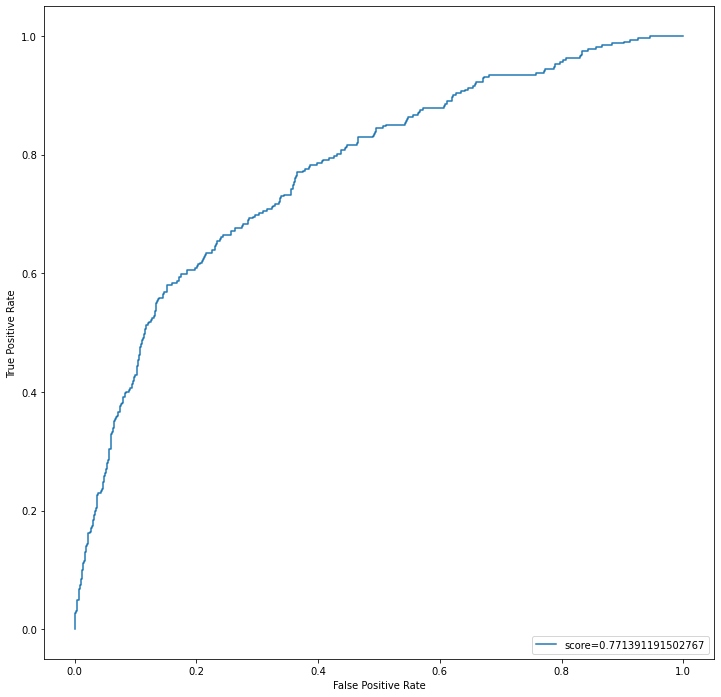

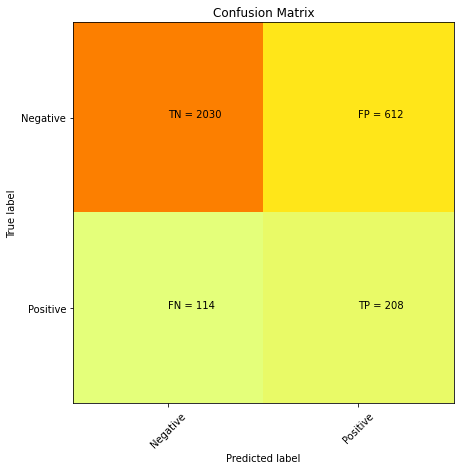


Classification report

              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85      2642
         1.0       0.25      0.65      0.36       322

    accuracy                           0.76      2964
   macro avg       0.60      0.71      0.61      2964
weighted avg       0.87      0.76      0.80      2964


_________________________________________


In [48]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid.values, y_valid.values

# X,y = X_test.values, y_test.values

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.5).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [ ]:
df_y.value_counts()

In [49]:
RF_model = model_final._final_estimator

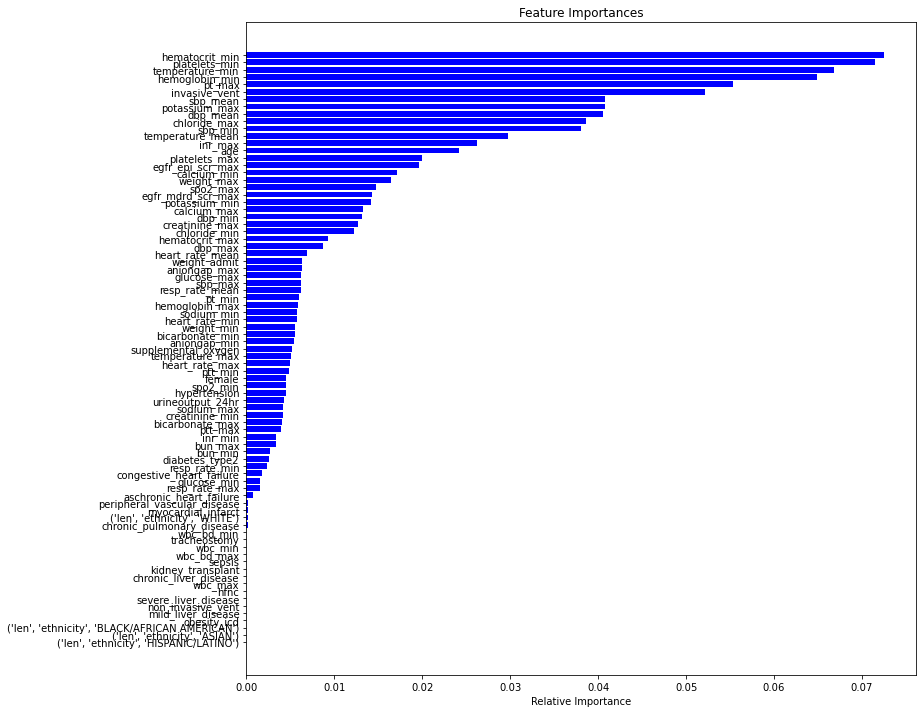

In [50]:
importances = RF_model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.rcParams["figure.figsize"] = (12,12)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Histograms

In [ ]:
# combining X_test,y_test and y_pred in one dataset
# del(df_test_all)
df_test_all = X_valid.copy()
df_test_all['y_actual'] = y_valid
df_test_all['y_pred'] = y_pred
# df_test_all

In [ ]:
# labeling the category of error

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

# df_test_all

In [ ]:
# get data for True negative and  False positive and compare their distribution.
# It plots the distribution and prints Jensen-Shanon distance.
# from functions_compare_distribution import compare_hist_df
from dfwiz import dfwiz, dfwiz_compare
# healthy patients
TN = df_test_all.query("error_category == 0")[X_test.columns] # True negative
FP = df_test_all.query("error_category == 1")[X_test.columns] # False positive

if len(TN) == 0 or len(FP) == 0:
    print("Error! one of the dataframes are empty")
else:
    # compare_hist_df(TN, FP) # plot distributions and output Jensen-Shanon distance.
    dfwiz_compare(FP, TN,label=['FP', 'TN'])

## Decision Tree on validation set to differentiate between 

In [51]:
# labeling the category of error
# del(df_test_all)


# X_test_transformed = model_final.named_steps['scaler'].transform(X_test)
X_test_all_imputed = model_final.named_steps['imputer'].transform(X_valid)

df_test_all = pd.DataFrame(X_test_all_imputed, columns=X_valid.columns)

df_test_all['y_actual'] = y_valid.values.ravel()
df_test_all['y_pred'] = y_pred

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3


df_test_all['pred_True'] = 0
for i in df_test_all.index:
     if df_test_all['error_category'][i] == 0 or df_test_all['error_category'][i] == 2: # All true predictions
          df_test_all['pred_True'][i] = 1
     else:
          df_test_all['pred_True'][i] = 0 # All false predictions   

# df_test_all

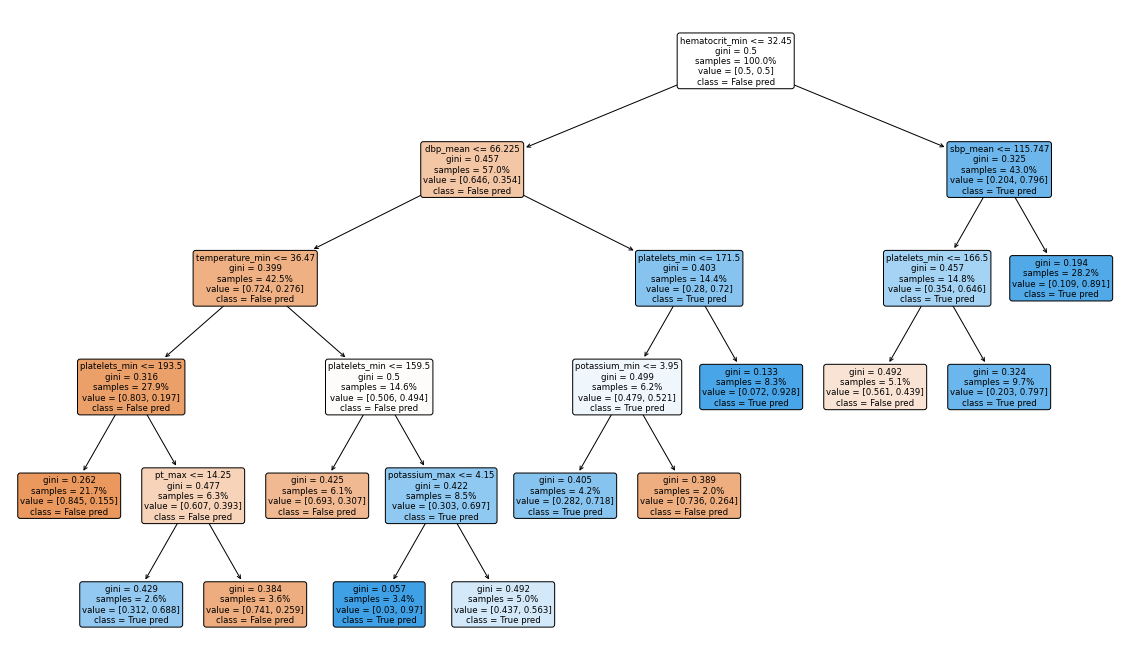

In [52]:
# train a descision tree to predict the model error in negative cases ('True negative' vs 'False positive'). 
from sklearn import tree


class_names = ['False pred', 'True pred' ]
df1 = df_test_all.copy()
X1 = df1[X_valid.columns]
y1 =  df1[['pred_True']]
clf = tree.DecisionTreeClassifier(max_depth = 5 , class_weight='balanced', random_state=42, criterion="gini", min_impurity_decrease = 0.005)
clf = clf.fit(X1, y1)

# plot the tree
plt.figure(figsize=(20,12))
tree.plot_tree(clf,
               feature_names = list(X1.columns), 
               rounded=True, 
               filled = True,
               proportion = True,
               class_names = class_names);


In [53]:
X_train_imputed_array = model_final.named_steps['imputer'].transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train.columns)

y_error_t = clf.predict(X_train_imputed)

X_train_True = X_train.loc[(y_error_t==1)]
y_train_True = y_train.loc[(y_error_t==1)]


X_train_False = X_train.loc[(y_error_t==0)]
y_train_False = y_train.loc[(y_error_t==0)]




X_valid_imputed_array = model_final.named_steps['imputer'].transform(X_valid)
X_valid_imputed = pd.DataFrame(X_valid_imputed_array, columns=X_valid.columns)

y_error_v = clf.predict(X_valid_imputed)

X_valid_True = X_valid.loc[(y_error_v==1)]
y_valid_True = y_valid.loc[(y_error_v==1)]


X_valid_False = X_valid.loc[(y_error_v==0)]
y_valid_False = y_valid.loc[(y_error_v==0)]


In [54]:
X_train_True, y_train_True = up_sample(X_train_True, y_train_True,'outcome')
X_train_False, y_train_False = up_sample(X_train_False, y_train_False,'outcome')



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



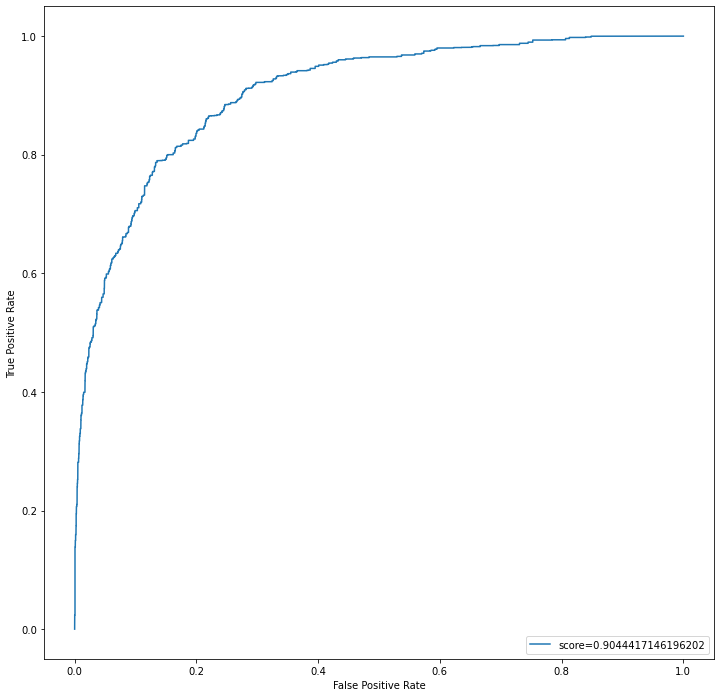

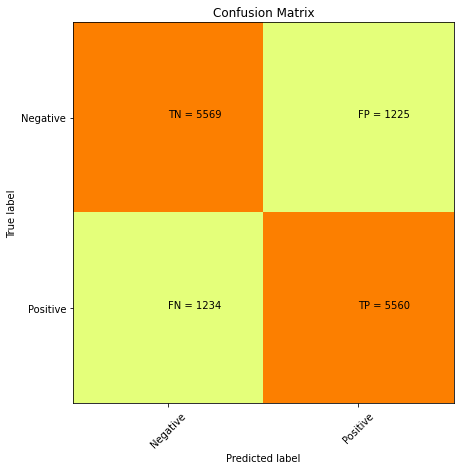


Classification report

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      6794
         1.0       0.82      0.82      0.82      6794

    accuracy                           0.82     13588
   macro avg       0.82      0.82      0.82     13588
weighted avg       0.82      0.82      0.82     13588


_________________________________________


In [55]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':100,'model__max_depth': 50
,'model__min_samples_leaf': 250, 'model__min_samples_split': 250}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_True)*sample_ratio)
X, y = resample(X_train_True.values, y_train_True.values, n_samples=n_samples, stratify=y_train_True.values, random_state=10)
model_final_true = copy.deepcopy(pipe)
model_final_true.set_params(**best_params2)
model_final_true.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final_true.predict(X)
y_pred_proba = model_final_true.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


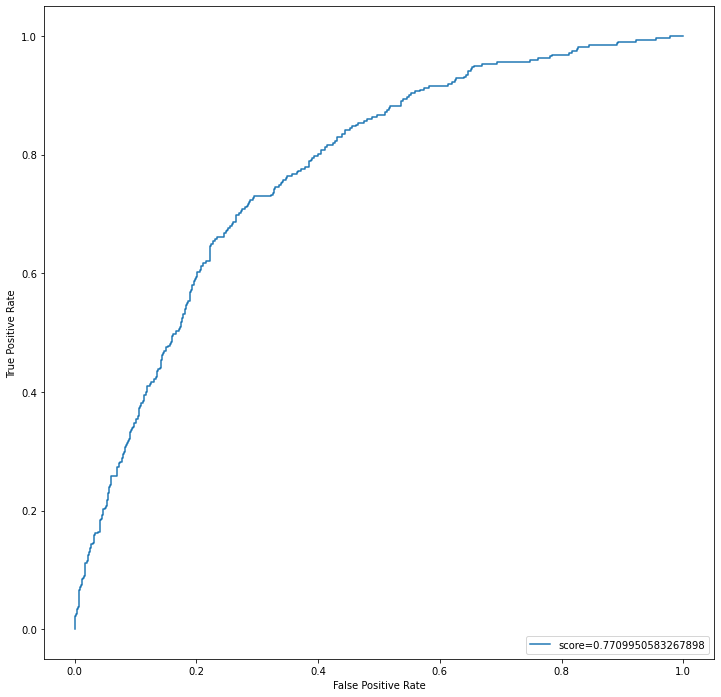

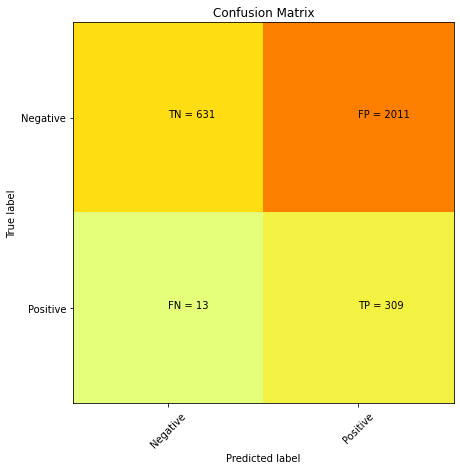


Classification report

              precision    recall  f1-score   support

         0.0       0.98      0.24      0.38      2642
         1.0       0.13      0.96      0.23       322

    accuracy                           0.32      2964
   macro avg       0.56      0.60      0.31      2964
weighted avg       0.89      0.32      0.37      2964


_________________________________________


In [56]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid.values, y_valid.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final_true.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)




______________________________________________________________________________________________________________________________________________________

Train Accuracy:



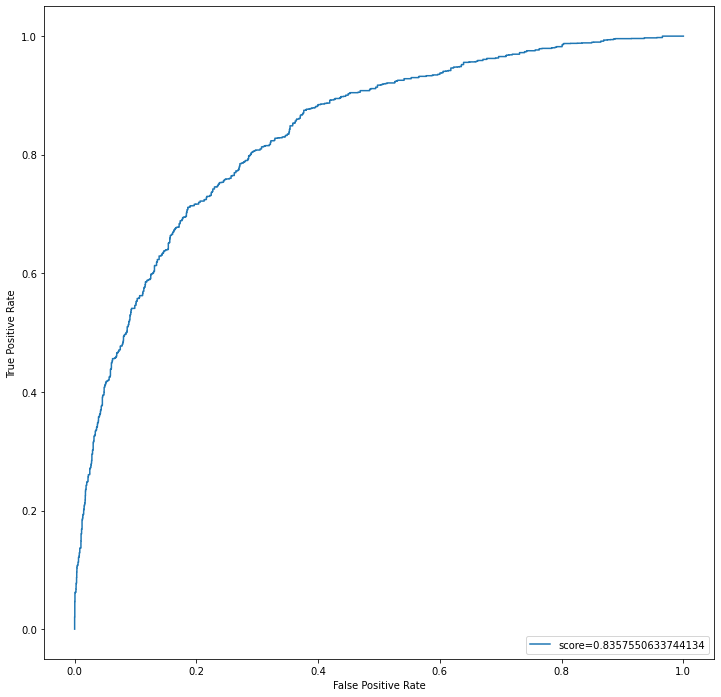

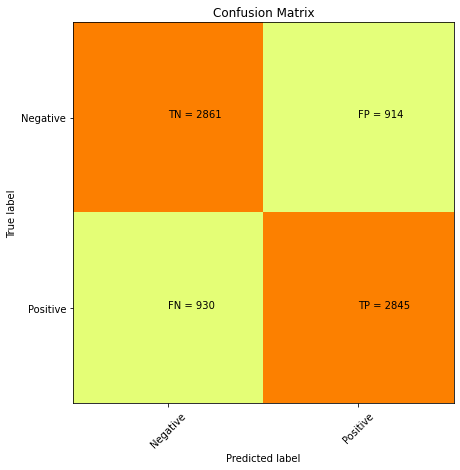


Classification report

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76      3775
         1.0       0.76      0.75      0.76      3775

    accuracy                           0.76      7550
   macro avg       0.76      0.76      0.76      7550
weighted avg       0.76      0.76      0.76      7550


_________________________________________


In [57]:
# manual params setting
# best_params2 = {'model__n_estimators':300,'model__max_depth': 40
# ,'model__min_samples_leaf': 0.1, 'model__min_samples_split': 0.1}

best_params2 = {'model__n_estimators':200,'model__max_depth': 40
,'model__min_samples_leaf': 200, 'model__min_samples_split': 200}


# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_False)*sample_ratio)
X, y = resample(X_train_False.values, y_train_False.values, n_samples=n_samples, stratify=y_train_False.values, random_state=10)
model_final_false = copy.deepcopy(pipe)
model_final_false.set_params(**best_params2)
model_final_false.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final_false.predict(X)
y_pred_proba = model_final_false.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


Test on train false

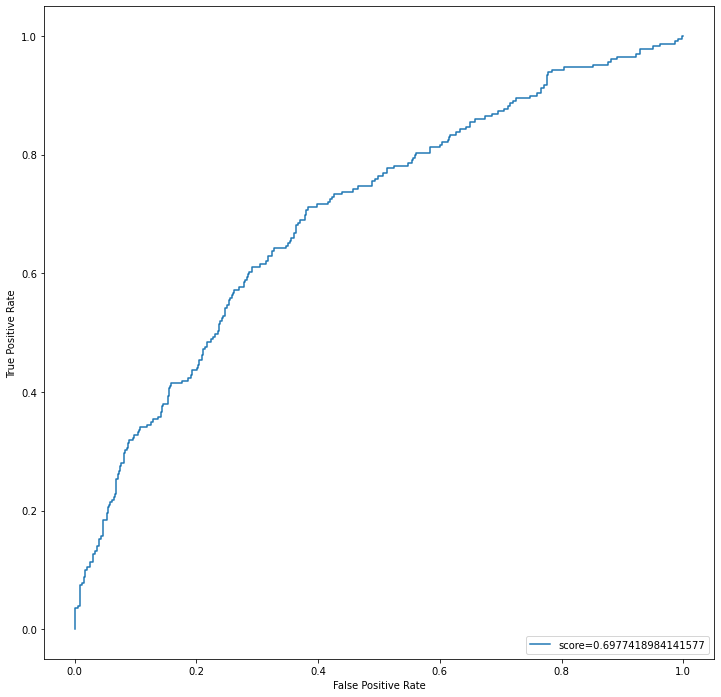

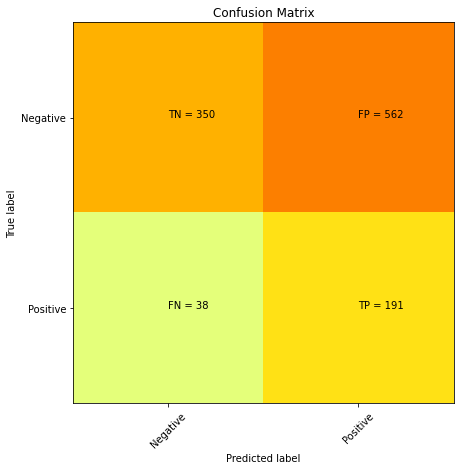


Classification report

              precision    recall  f1-score   support

         0.0       0.90      0.38      0.54       912
         1.0       0.25      0.83      0.39       229

    accuracy                           0.47      1141
   macro avg       0.58      0.61      0.46      1141
weighted avg       0.77      0.47      0.51      1141


_________________________________________


In [58]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_valid_False.values, y_valid_False.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final_false.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [59]:
X,y = X_test, y_test

y_pred_proba_list = []
for i in range(len(X)):
    X_imputed = model_final.named_steps['imputer'].transform(X.iloc[[i]])
    tree_predict = clf.predict(X_imputed)
    if(tree_predict == 1):
        # sth = model_final.predict_proba(X.iloc[[i]])
        # y_pred_proba[i] = list(sth[0])
        y_pred_proba_list.insert(i, list(model_final_true.predict_proba(X.iloc[[i]])[0]))
    else:
        y_pred_proba_list.insert(i, list(model_final_false.predict_proba(X.iloc[[i]])[0]))

y_pred_proba = np.array(y_pred_proba_list)


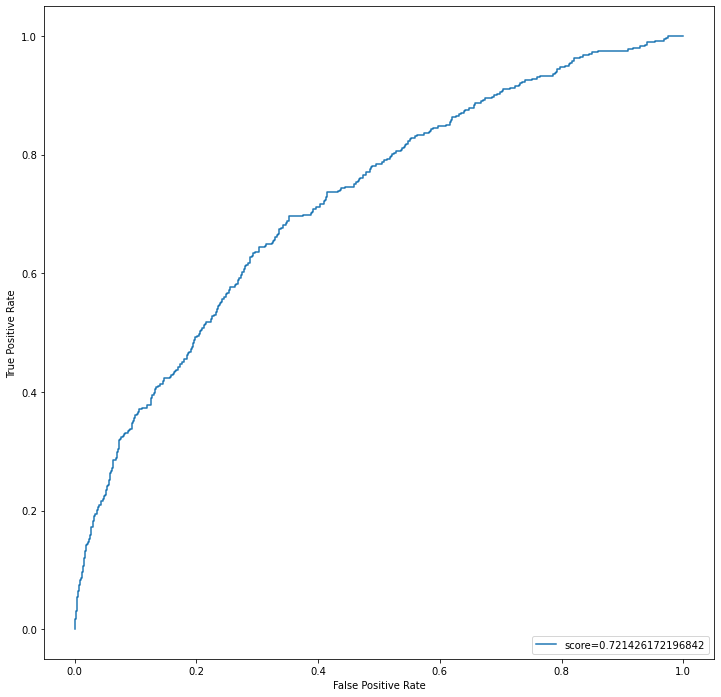

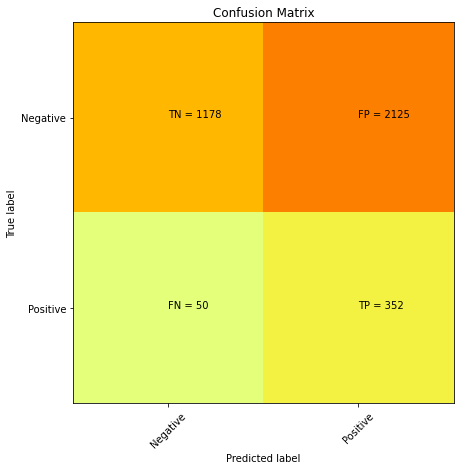


Classification report

              precision    recall  f1-score   support

         0.0       0.96      0.36      0.52      3303
         1.0       0.14      0.88      0.24       402

    accuracy                           0.41      3705
   macro avg       0.55      0.62      0.38      3705
weighted avg       0.87      0.41      0.49      3705


_________________________________________


In [60]:
y_pred  = (y_pred_proba[:,1] >= 0.4).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)